# LinUCB loop (DD)

## Principle

## Results



+ Conclusion:


## Notes

+ PR: Modifications
  + suppression de qq code mort
  + le dataset n'est généré que 1 seule fois avec un SEED fixe. On utilise le même dataset pour ttes les expérimentations
  + Le RND_SEED est modifié à chaque iteration (et n'impacte plus le dataset)  
  + Passage en version 10 du Dataset et partage du Dataset par les clients pairs/impairs et non par ratio 80/20
  + Ajout du paramètre VERSION (=9 ou 10)
  + Sauvegarde des agents avec données

+ Remarques PR: 
  + Le DataSelector ADBMSBufferCacheStatesRandomBufferSelector ne fonctionne pas avec avec KFOO => inversion de matrice error / Singular matrix
  + ADBMSBufferCacheStatesFullSequentialSelector fonctionne dans les 2 cas
  + KFOO est corrigé avec un np.asmatrix() comme HS...
  + KFOO 730its/s, HS 350its/s, obtenus en désactivant le trange d'itération sur ExperimentNumber. Il y a déjà un trange dans Agent() sur les épisodes. 
  + La performance CPU de HS est presque identique à KFOO lorsqu'on n'utilise plus pinv()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Load ../workloads...
All possible perf levels: [0.9   0.95  0.965 0.98  0.99  0.995 0.997] Choose:0.98
Workloads data access. All possible rand types distribution: ['gaussian' 'special' 'uniform' 'pareto'] Choose:['special', 'gaussian', 'uniform', 'pareto']
All possible client connections count: [ 1  2  3  4  5  6  7  8 10 12] Choose:[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Tolerancy over SLA max latency: 0.0020000000000000018
Buffer values count per workload: 64
Separate train/test datasets by clients Train:[2, 4, 6, 8, 10, 12] test:[1, 3, 5, 7]
WILL TRAIN ON 144 WORKLOADS:
['5 0.1 2 Ga' '5 0.1 2 Sp' '5 0.1 2 Un' '5 0.1 4 Un' '5 0.1 6 Ga'
 '5 0.1 6 Sp' '5 0.1 6 Un' '15 1.0 2 Sp' '15 1.0 2 Un' '15 1.0 4 Sp'
 '15 1.0 6 Ga' '15 1.0 6 Sp' '15 1.0 6 Un' '22 1.0 2 Ga' '22 1.0 2 Sp'
 '22 1.0 2 Un' '22 1.0 4 Sp' '22 1.0 4 Un' '22 1.0 6 Ga' '22 1.0 6 Sp'
 '22 1.0 6 Un' '30 1.0 2 Ga' '30 1.0 2 Sp' '30 1.0 2 U

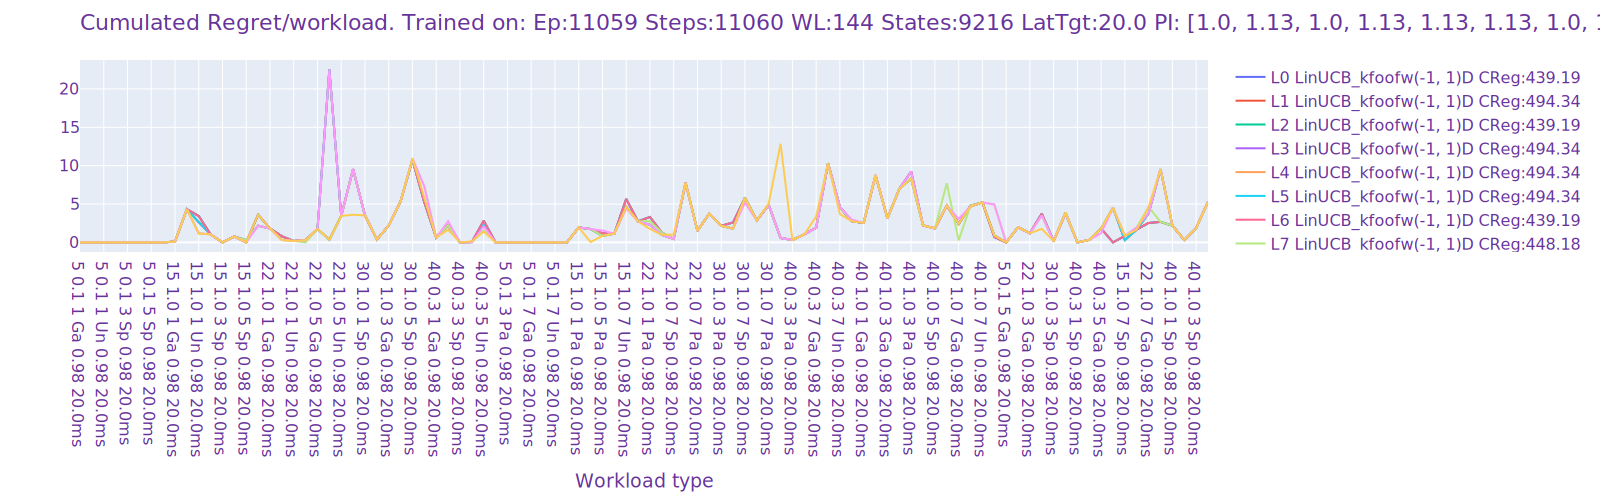

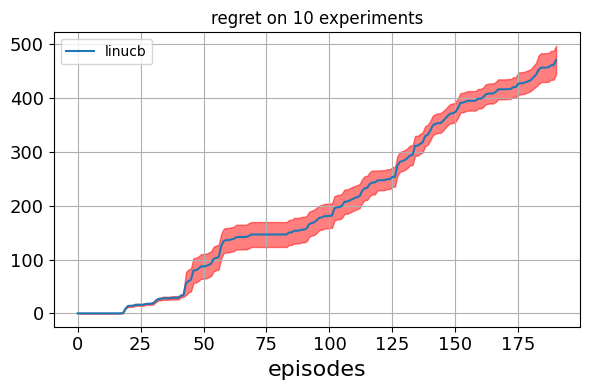

In [3]:
%load_ext autoreload
%autoreload 2
import sys
import os
sys.path.append(os.path.abspath(os.pardir))

from tqdm import trange
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import clear_output

import bandits.datasource.adbms_dataframe as ds
import bandits.reward as rw
from bandits.gym_env import VSEnv, VSMonitor
from bandits.agent import VSAgent
from bandits.policy_linucb_kfoofw import LinUCBPolicy_kfoofw
from bandits.policy_linucb_hs import HSLinUCBPolicy

#qpslat_weights="01"   # QPS is not used in performance computation (weigth is 0%), the objective is to maintain te Latency (weigth is 100%). Other options is "19" (10% for QPS, 90% for Latency)
PLOTLY_RENDERER="svg" # "plotly_mimetype+notebook": Ex: png, jpg, svg
IPERF_LEVEL=0.98    # [0.9   0.95  0.965 0.98  0.99  0.995 0.997]
VERSION=9

# Choose ratio=80 for 80% train and 20% test. Choose ratio=0 for a separation by clients. Ex Train on all Odd wl_clients num and test on even wl_clients num
datasets = ds.TrainTestDataSets(testastrain=False, ratio=0, version=VERSION, perf_level=IPERF_LEVEL, randtypes=[ "special", "gaussian", "uniform", "pareto" ], clients=[1,2,3,4,5,6,7,8,9,10,11,12], seed=42, verbose=1)

OBSERVATION_SPACE_ELEMS = [
####    "tables",                      # Not significant while in production the DB schema is totaly different than the one built by Sysbench. DB Size should be sufficient
####    "tables_rows",                 # Not significant while in production the DB schema is totaly different than the one built by Sysbench. DB Size should be sufficient
#    "iperf01",                      # Current performance indicator based on WPS and Latency, 01 is computed with weigths as follow: 0% QPS and 100% Latency
    "db_size_mb",                    # Initial DB size after creation of all tables+indexes and before the workload with all clients
    "sysbench_filtered.latency_mean",      # [0, 1000] ms. Filtered latency from client. In inference/live mode, it should be a predicted value (see predictor.ipynb using XGBoost)
#    "buf_size_idx",                      # Index form of the buffer size value [0, 63]
    "observation.normalized_buf_size",     # [0., 1.] Taille normalisée courante du buffer cache
#    "perf_target_level",           # [0., 1.] Objectif de performance cible. Est une valeur fixe lors des entrainements (1 modèle pour 1 objectif de perf)
#    "latency_threshold",           # In ms. Est une valeur fixe lors des entrainements
    "observation.cache_used_pages_ratio",
    "observation.cache_hit_ratio",
    "extra_info.usage.db_size_initial.IndexSizeMB", # Initial Indexes DB size 
    "extra_info.usage.qps",          # QPS picked on server ("Questions" Global status variable throughput)
    "extra_info.global_status.KBps", # Kilo Bytes per seconds picked on server with "Bytes_sent" Global status variable throughput
    "observation.write_wait_ratio",  # Seems not relevant and usable on MariaDB
#    "extra_info.global_status.threads_running_start", # NOT POWERFULL!!?? The number of connections currently running an SQL query. Be carefull of a Bug in some MariaDB versions!! => TOO MUCH NOISE ON ITS VALUE!!!!!
    "extra_info.global_status.created_tmp_tables_diff", # ?
    "extra_info.global_status.handler_delete_diff", # ?
    "extra_info.global_status.handler_update_diff", # ?
    "extra_info.global_status.handler_write_diff", # ?
    "extra_info.global_status.innodb_buffer_pool_read_requests_diff",
    "extra_info.global_status.innodb_buffer_pool_write_requests_diff",
    "extra_info.global_status.innodb_buffer_pool_wait_free_diff",
    "extra_info.global_status.innodb_data_reads_diff",
    "extra_info.global_status.innodb_data_written_diff",
    "extra_info.global_status.max_used_connections_end",
    "extra_info.global_status.threads_running_end",
    "extra_info.global_status.threads_connected_end",
    "extra_info.global_status.innodb_buffer_pool_bytes_dirty_end", # Seems cool to have it
    "extra_info.global_status.innodb_buffer_pool_pages_free_end",  # Seems cool to have it
#    "extra_info.global_status.innodb_buffer_pool_pages_data_diff",
    "extra_info.global_status.innodb_buffer_pool_bytes_dirty_diff", # Seems cool to have it
    "extra_info.global_status.innodb_buffer_pool_pages_free_diff",  # Seems cool to have it
    "extra_info.global_status.information_schema.innodb_metrics.lock_row_lock_time_max",
    "extra_info.global_status.information_schema.innodb_metrics.lock_row_lock_waits",
    "extra_info.global_status.information_schema.innodb_metrics.os_pending_reads",
    "extra_info.global_status.information_schema.innodb_metrics.os_pending_writes",
    "extra_info.global_status.information_schema.innodb_metrics.file_num_open_files",
    "extra_info.global_status.information_schema.innodb_buffer_pool_stats.MODIFIED_DATABASE_PAGES", # Sounds COOL to have it!!
    "extra_info.global_status.information_schema.innodb_buffer_pool_stats.PAGES_READ_RATE",
    "extra_info.global_status.information_schema.innodb_buffer_pool_stats.PAGES_CREATE_RATE",
#    "extra_info.global_status.information_schema.innodb_buffer_pool_stats.PAGES_WRITTEN_RATE",  # CATASTROPHIC at an incredible point !!!
    "extra_info.global_status.information_schema.innodb_buffer_pool_stats.READ_AHEAD_RATE",
    "extra_info.global_status.information_schema.innodb_buffer_pool_stats.READ_AHEAD_EVICTED_RATE",
    "extra_info.global_status.information_schema.innodb_buffer_pool_stats.PAGES_MADE_YOUNG_RATE", # Sounds COOL to have it!!
    "extra_info.global_status.information_schema.innodb_buffer_pool_stats.POOL_SIZE", # Sounds COOL to have it!!
    "extra_info.global_status.information_schema.innodb_buffer_pool_stats.FREE_BUFFERS",
    "extra_info.global_status.information_schema.innodb_buffer_pool_stats.DATABASE_PAGES",
    "extra_info.global_status.information_schema.innodb_buffer_pool_stats.OLD_DATABASE_PAGES",
    "extra_info.global_status.information_schema.innodb_buffer_pool_stats.PENDING_DECOMPRESS",       #?
    "extra_info.global_status.information_schema.innodb_buffer_pool_stats.PENDING_READS",       #?
    "extra_info.global_status.information_schema.innodb_buffer_pool_stats.PENDING_FLUSH_LRU",       #?
    "extra_info.global_status.information_schema.innodb_buffer_pool_stats.PENDING_FLUSH_LIST",       #?
    "extra_info.global_status.information_schema.innodb_buffer_pool_stats.PAGES_MADE_YOUNG",
    "extra_info.global_status.information_schema.innodb_buffer_pool_stats.PAGES_NOT_MADE_YOUNG",
    "extra_info.global_status.information_schema.innodb_buffer_pool_stats.PAGES_MADE_NOT_YOUNG_RATE",
    "extra_info.global_status.information_schema.innodb_buffer_pool_stats.NUMBER_PAGES_READ",       #?
    "extra_info.global_status.information_schema.innodb_buffer_pool_stats.NUMBER_PAGES_CREATED",    #?
    "extra_info.global_status.information_schema.innodb_buffer_pool_stats.NUMBER_PAGES_WRITTEN",    # ? 
    "extra_info.global_status.information_schema.innodb_buffer_pool_stats.NUMBER_PAGES_GET",
    "extra_info.global_status.information_schema.innodb_buffer_pool_stats.HIT_RATE",
    "extra_info.global_status.information_schema.innodb_buffer_pool_stats.YOUNG_MAKE_PER_THOUSAND_GETS",         #?
    "extra_info.global_status.information_schema.innodb_buffer_pool_stats.NOT_YOUNG_MAKE_PER_THOUSAND_GETS",         #?
    "extra_info.global_status.information_schema.innodb_buffer_pool_stats.NUMBER_PAGES_READ_AHEAD",         #?
    "extra_info.global_status.information_schema.innodb_buffer_pool_stats.NUMBER_READ_AHEAD_EVICTED",         #?
    "extra_info.global_status.information_schema.innodb_buffer_pool_stats.LRU_IO_TOTAL",
    "extra_info.global_status.information_schema.innodb_buffer_pool_stats.LRU_IO_CURRENT",
#    "extra_info.global_status.information_schema.innodb_buffer_pool_stats.UNCOMPRESS_TOTAL",
#    "extra_info.global_status.information_schema.innodb_buffer_pool_stats.UNCOMPRESS_CURRENT",
]

ACTION_MINMAX = (-1,1)  # The Min and Max action values. Arms count and the position of the "STAY" arm are depending on it.
#ON_TERMINATE=-1 # Environement option. -1=Never teminate (the default, just truncate on Timelimit), 0=Terminate with Zero bonus on reward, N=Terminate with a bonus added to the reward (may exceed 1)
TRAINING_COVERAGE=1.2 # Coverage of the total states present in dataset. 1.0 means that almost all the dataset will be covered (depends also on the random distribution that may repeat twice the same state)
TRAINING_STEPS_PER_EPISODE = 1    # Important to take benefit of the decreasing exploration vs explotation tradeoff
TRAINING_VERBOSITY=0 #5
NORMALIZE_OBS=False
# Explore vs exploit
#ALPHA=0.6
ALPHA=0.99 #DD 2
# In Labo mode, we consider that having usage of client's latency in LinUCB context, in both learning and test, is not an issue
# In Prod mode, we can access client's latency only during learning process. Latency cannot be part of the LinUCB context. The only viable and comparable baseline is BFR (Buffer Filling Rate) baseline.
LABO_EXPE=False
# Labo or Prod ?
if LABO_EXPE:
    TRAINING_USE_SLA_PROTECT=True #use or NOT Use the reactive mode to protect the SLA. Let see where we are going without this protection...
    TEST_USE_SLA_PROTECT = True #True if "sysbench_filtered.latency_mean" in OBSERVATION_SPACE_ELEMS else False
else:
    TRAINING_USE_SLA_PROTECT=False #It makes no sense to put it at True if we cannot use it in test..
    TEST_USE_SLA_PROTECT = False   # Must be like that (False)
    OBSERVATION_SPACE_ELEMS.remove("sysbench_filtered.latency_mean") # Ensure latency is not used in context

ExperimentNumber = 10
train_regret = []
test_regret = []
graph_tests = None

for expe in range(ExperimentNumber): #DD trange(ExperimentNumber):
    RND_SEED = 4242+expe

    # Discrete reward is either 0 or 1 depending on the Arm (is it the good one or not?). 
    # Continous reward in range [-1., 1.] is computed. The best arm is the one having the maximum value
    reward_learning = rw.ADBMSBufferCacheRewardContinousV3E(action_minmax=ACTION_MINMAX)
    print(f'K_ARMS:{reward_learning.actions.count()} STAY_ARM_IDX:{reward_learning.actions.armStay()}')

    SIGMA_TIPPING_RATIO=-1. #-1 #0.9375 # The sigma value for the random gaussian distribution around the "mean" (or "mu"), the point of SLA tipping. If <0 use the auto-computing based on tipping point.
    # 1- 
    #ds_train = ds.ADBMSBufferCacheStatesFullRandomSelector(datasets.df_train, sigma_tipping_ratio=SIGMA_TIPPING_RATIO, seed=RND_SEED)
    # 2- ok but longer than 3
    #ds_train = ds.ADBMSBufferCacheStatesRandomBufferSelector(datasets.df_train, sigma_tipping_ratio=SIGMA_TIPPING_RATIO, seed=RND_SEED)
    # 3- sligthly better than ds_train5
    #ds_train = ds.ADBMSBufferCacheStatesSequentialSelector(datasets.df_train, topdown=True) # At each reset choose the workload from the current episode index, go to the top or bottom state of the workload as specified by topdown argument.
    # 4- Optimal ?
    # Choix PR
    ds_train = ds.ADBMSBufferCacheStatesFullSequentialSelector(datasets.df_train)  # Start at the begining of the dataset and go to the next state at each reset. When bottom state is reached, next reset will go to the next workload (auto rewind) 
    # 5-
    #ds_train = ds.ADBMSBufferCacheStatesTopDownRockerSelector(datasets.df_train)            # Start sequentialy each workload twice. First from Top, second from Bottom
    
    # Choix DD avec HSLinUCB mais pb. singular matrix avec KFOO
    #ds_train = ds.ADBMSBufferCacheStatesRandomBufferSelector(datasets.df_train, sigma_tipping_ratio=SIGMA_TIPPING_RATIO, seed=RND_SEED)
    
    ds_train.prepareContext(OBSERVATION_SPACE_ELEMS, normalize=NORMALIZE_OBS)

    #TRAIN    
    env_train = VSMonitor(VSEnv(ds_train, reward=reward_learning, notify_react=TRAINING_USE_SLA_PROTECT, max_steps_per_episode=TRAINING_STEPS_PER_EPISODE))
    policy = LinUCBPolicy_kfoofw(ACTION_MINMAX, ctx=ds_train.contextElems(), alpha=ALPHA)
    #policy = HSLinUCBPolicy(ACTION_MINMAX, ctx=ds_train.contextElems(), alpha=ALPHA)
    linucb_agent = VSAgent(policy)
    linucb_agent.learn(env_train, TRAINING_COVERAGE, verbose=TRAINING_VERBOSITY)
    # Show learning graph!
    #linucb_agent.showLearnFig(head_title=f"LEARN/{policy.name} TotalSteps:{env_train.unwrapped.total_steps}", renderer=None)

    total_ep = env_train.unwrapped.cur_episode
    cur_train_regret = env_train._regret_per_episode[:total_ep].cumsum()
    train_regret.append(cur_train_regret)
    
    # TEST
    ds_test = ds.ADBMSBufferCacheStatesTopDownRockerSelector(datasets.df_test) 
    TEST_EPISODES_COUNT = -2    # If <0, abs(EPISODES_COUNT) is a multiple of workloads count 
    TEST_STEPS_PER_EPISODE = -1 # If <0, abs(STEPS_PER_EPISODE) is a multiple of buffer values count
    ds_test.prepareContext(OBSERVATION_SPACE_ELEMS, normalize=NORMALIZE_OBS, with_scaler=ds_train.min_max_scaler) # "with_scaler" is ignored if No normalization is enabled
    # Environement for test. 
    env_test = VSMonitor(VSEnv(ds_test, reward=reward_learning, notify_react=TEST_USE_SLA_PROTECT, max_steps_per_episode=TEST_STEPS_PER_EPISODE))
    linucb_agent.predict(env_test, episodes_max=TEST_EPISODES_COUNT, verbose=0)

    total_ep = env_test.unwrapped.cur_episode
    cur_test_regret = env_test._regret_per_episode[:total_ep].cumsum()
    test_regret.append(cur_test_regret)
    print(f'Env test cumulated regret: {env_test._reg_performance}')

    if expe == 0:
        graph_tests = env_test.graphPerWorkload(f"Cumulated Regret/workload. Trained on: {env_train.unwrapped.msgStatus()} {env_train.unwrapped.desc()}")
    graph_tests.addCurve(f"L{expe} {policy.name} CReg:{round(env_test.getRegretPerformance(),2)}", y=env_test.resultPerWorkload(), perf=env_test.getRegretPerformance())

    linucb_agent.save(filever=f'{VERSION}_loop{expe}', verbose=1, 
                      min_max_scaler=ds_train.min_max_scaler, expe=expe, 
                      train_alpha=ALPHA, train_regret=cur_train_regret, train_reg_perf=env_train.getRegretPerformance(),
                      train_reg_results=env_train.resultPerWorkload(), 
                      test_regret=cur_test_regret, test_reg_perf=env_test.getRegretPerformance())    

    env_train.close()
    env_test.close()

fig = graph_tests.figure()
fig.show(renderer=None) # svg is cleaner but not in Gitlab. None is the best in VSCode
fig.show(renderer=PLOTLY_RENDERER) # svg is cleaner but not in Gitlab. None is the best in VSCode

#train_regret_exp = np.empty((len(train_regret), len(train_regret[0])))
#for experiment in range(len(train_regret)):
#    train_regret_exp[experiment] = train_regret[experiment]
#mean_train_regret_exp = np.mean(train_regret_exp, axis=0)
#std_train_regret_exp = np.std(train_regret_exp, axis=0)
#with open("train_regret_linucb.bin", 'wb') as f:
#    np.save(f, train_regret_exp)

test_regret_exp = np.empty((len(test_regret), len(test_regret[0])))
for experiment in range(len(test_regret)):
    test_regret_exp[experiment] = test_regret[experiment]
mean_test_regret_exp = np.mean(test_regret_exp, axis=0)
std_test_regret_exp = np.std(test_regret_exp, axis=0)
x = [i for i in range(len(mean_test_regret_exp))]
fig, ax = plt.subplots(figsize=(6, 4), nrows=1, ncols=1)
plt.xlabel('episodes',fontsize=16)
plt.xticks(fontsize=13,fontweight='normal')
plt.yticks(fontsize=13,fontweight='normal')
ax.plot(x,mean_test_regret_exp,label=linucb_agent.policy.name)
ax.fill_between(x,mean_test_regret_exp-std_test_regret_exp, mean_test_regret_exp+std_test_regret_exp,alpha=0.5,color='r')
plt.title("regret on " + str(ExperimentNumber) + " experiments")
plt.legend(loc='best')
ax.grid()
plt.tight_layout()
plt.show()
with open("test_regret_linucb.bin", 'wb') as f:
    np.save(f, test_regret_exp)
    